In [1]:
%pylab inline
plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (12,4)

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pathlib

In [3]:
import numpy as np
import pandas as pd

In [4]:
DATA_DIR = pathlib.Path("data")

# Loading data

In [5]:
df = pd.read_csv("data/AEP_hourly.csv.zip", parse_dates=["Datetime"], index_col="Datetime")

In [6]:
df

,AEP_MW
Datetime,
2004-12-31 01:00:00,13478.0
2004-12-31 02:00:00,12865.0
2004-12-31 03:00:00,12577.0
2004-12-31 04:00:00,12517.0
2004-12-31 05:00:00,12670.0
...,...
2018-01-01 20:00:00,21089.0
2018-01-01 21:00:00,20999.0
2018-01-01 22:00:00,20820.0


## Fix timestamps

In [7]:
df.index.is_monotonic, df.index.is_unique

(False, False)

In [8]:
df = df.sort_index()
df

,AEP_MW
Datetime,
2004-10-01 01:00:00,12379.0
2004-10-01 02:00:00,11935.0
2004-10-01 03:00:00,11692.0
2004-10-01 04:00:00,11597.0
2004-10-01 05:00:00,11681.0
...,...
2018-08-02 20:00:00,17673.0
2018-08-02 21:00:00,17303.0
2018-08-02 22:00:00,17001.0


### New index

In [9]:
new_idx = pd.date_range("2004-10-01 01:00:00", "2018-08-03 00:00:00", freq="1H")

In [10]:
df[~df.index.duplicated(keep='first')]

,AEP_MW
Datetime,
2004-10-01 01:00:00,12379.0
2004-10-01 02:00:00,11935.0
2004-10-01 03:00:00,11692.0
2004-10-01 04:00:00,11597.0
2004-10-01 05:00:00,11681.0
...,...
2018-08-02 20:00:00,17673.0
2018-08-02 21:00:00,17303.0
2018-08-02 22:00:00,17001.0


In [11]:
dfi = df[~df.index.duplicated(keep='first')].reindex(new_idx)

In [12]:
dfi.index.is_monotonic, dfi.index.is_unique, dfi.index.freq

(True, True, <Hour>)

### Missing values

In [13]:
dfi.isnull().mean()

AEP_MW    0.000223
dtype: float64

In [14]:
dfi.ffill(inplace=True)

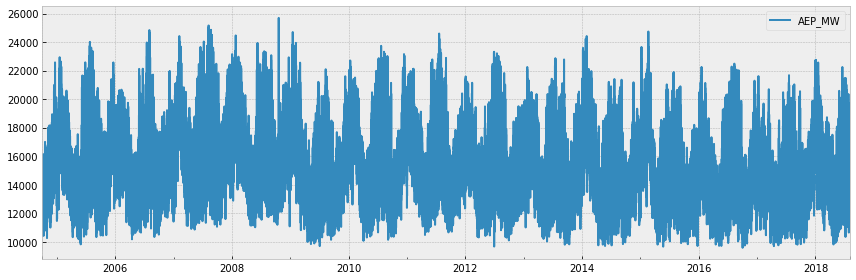

In [15]:
dfi.plot()
plt.tight_layout()

### Yearly pattern

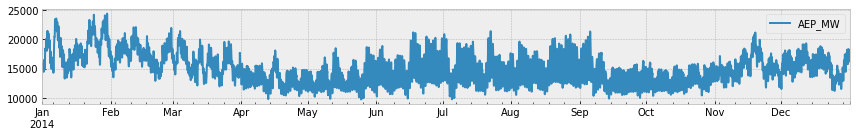

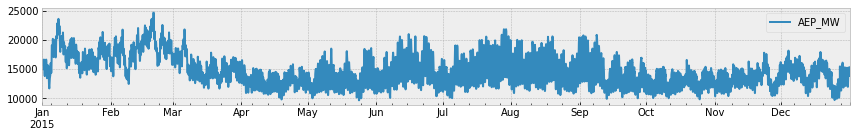

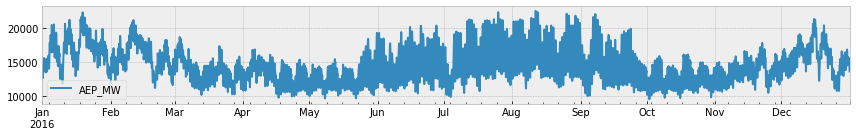

In [16]:
for year in ["2014", "2015", "2016"]:
    plt.figure(figsize=(12,2))
    dfi.loc[year].plot(ax=plt.gca())
    plt.tight_layout()
    plt.show()

### Daily pattern

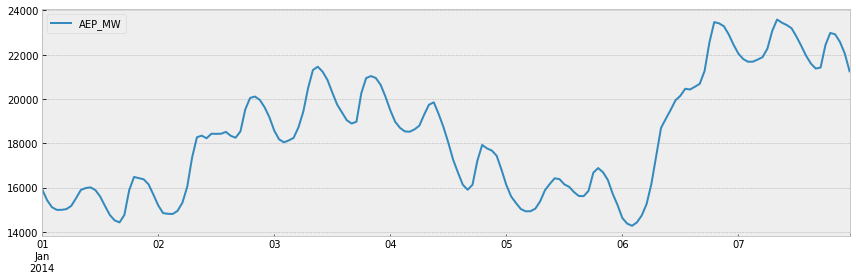

In [17]:
dfi.loc["2014-01-01":"2014-01-07"].plot()
plt.tight_layout()

### Monthly series

In [18]:
df_monthly = dfi.resample("1M").mean()

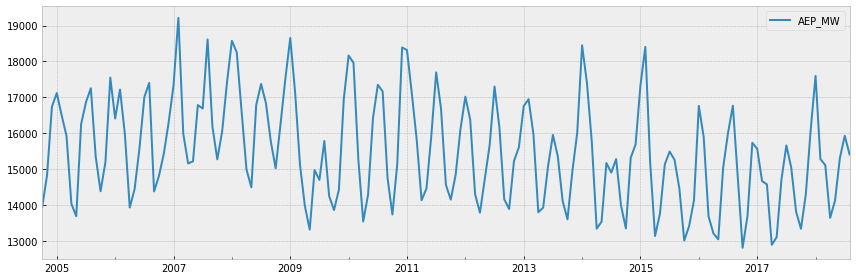

In [19]:
df_monthly.plot()
plt.tight_layout()

### Weekly series

In [20]:
df_weekly = dfi.resample("1W").mean()

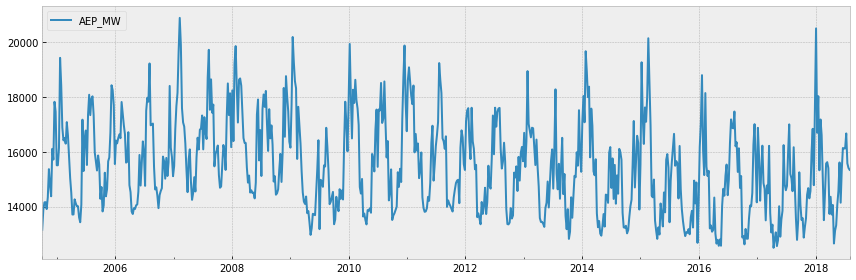

In [21]:
df_weekly.plot()
plt.tight_layout()

# ACF and PACF

In [22]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

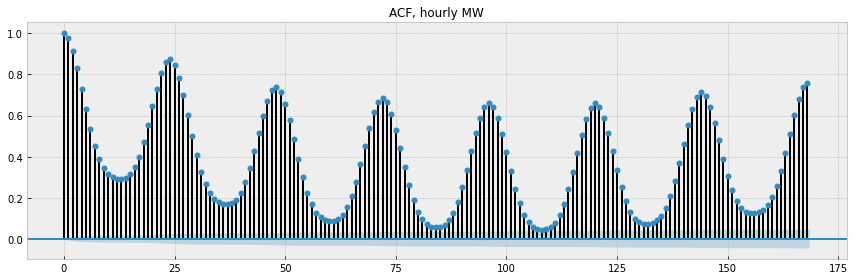

In [23]:
plot_acf(dfi, lags=168)
plt.title("ACF, hourly MW", fontsize=12)
plt.tight_layout()
plt.show()

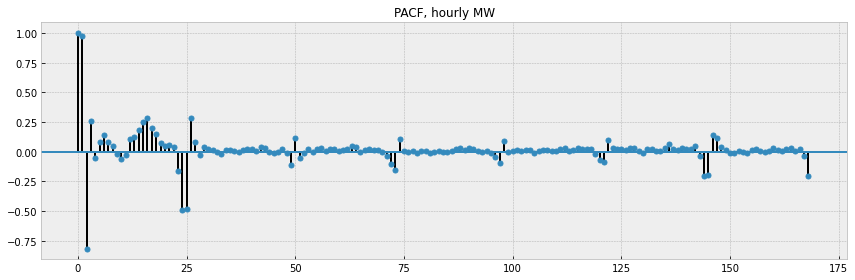

In [24]:
plot_pacf(dfi, lags=168)
plt.title("PACF, hourly MW", fontsize=12)
plt.tight_layout()
plt.show()

## Monthly series ACF and PACF

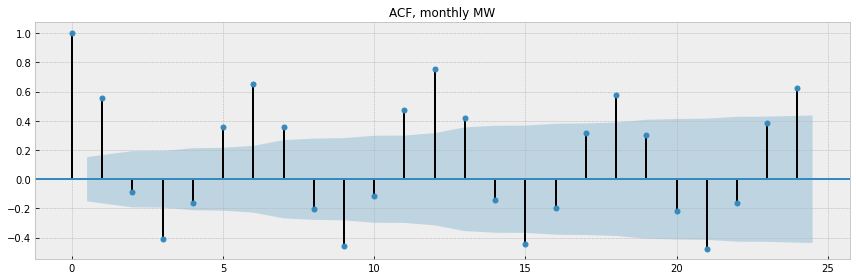

In [25]:
plot_acf(df_monthly, lags=24)
plt.title("ACF, monthly MW", fontsize=12)
plt.tight_layout()
plt.show()

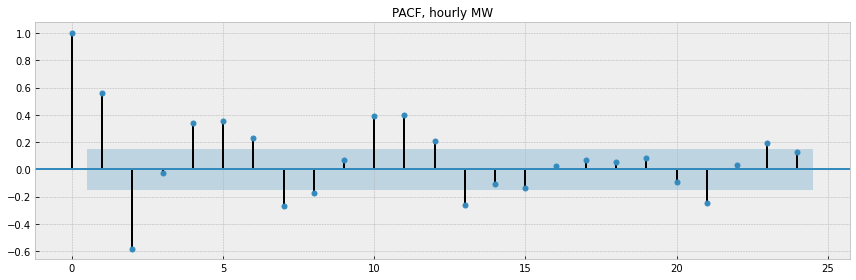

In [26]:
plot_pacf(df_monthly, lags=24)
plt.title("PACF, hourly MW", fontsize=12)
plt.tight_layout()
plt.show()

## Weekly series ACF and PACF

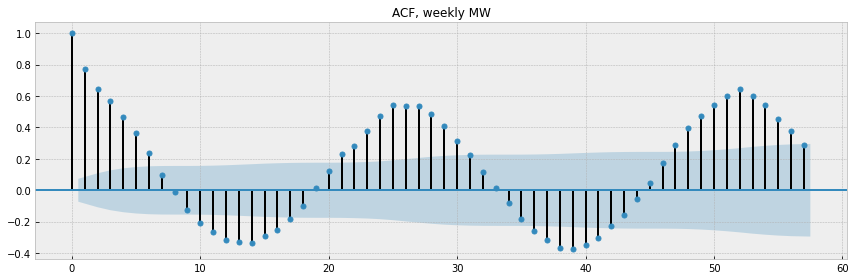

In [27]:
plot_acf(df_weekly, lags=57)
plt.title("ACF, weekly MW", fontsize=12)
plt.tight_layout()
plt.show()

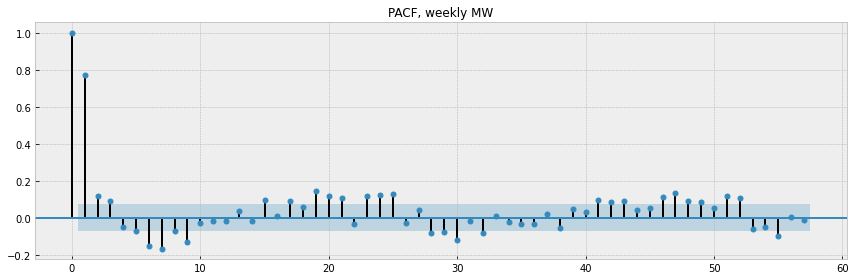

In [28]:
plot_pacf(df_weekly, lags=57)
plt.title("PACF, weekly MW", fontsize=12)
plt.tight_layout()
plt.show()

# SARIMA model

In [29]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [30]:
ar_order = (1, 2, 4, 5)
ma_order = (1, 3, 5)
diff_order = 0

s_order = (1, 0, 1, 6)

In [31]:
model = SARIMAX(df_monthly[:"2015"], order=(ar_order, diff_order, ma_order),
                seasonal_order=s_order)

## Fitting the model

In [32]:
res = model.fit()

In [33]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                               SARIMAX Results                                                
==============================================================================================================
Dep. Variable:                                                 AEP_MW   No. Observations:                  135
Model:             SARIMAX([1, 2, 4, 5], 0, [1, 3, 5])x(1, 0, [1], 6)   Log Likelihood               -1088.455
Date:                                                Mon, 08 Feb 2021   AIC                           2196.910
Time:                                                        13:42:08   BIC                           2225.963
Sample:                                                    10-31-2004   HQIC                          2208.716
                                                         - 12-31-2015                                         
Covariance Type:                                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6982      0.189      8.988      0.000       1.328       2.069
ar.L2         -0.7516      0.249     -3.025      0.002      -1.239      -0.265
ar.L4         -0.1898      0.186     -1.022      0.307      -0.554       0.174
ar.L5          0.2429      0.127      1.914      0.056      -0.006       0.492
ma.L1         -1.1461      0.112    -10.213      0.000      -1.366      -0.926
ma.L3          0.5109      0.155      3.298      0.001       0.207       0.815
ma.L5         -0.3573      0.118     -3.031      0.002      -0.588      -0.126
ar.S.L6        0.9943      0.009    108.042      0.000       0.976       1.012
ma.S.L6       -0.7626      0.137     -5.559      0.000      -1.032      -0.494
sigma2      6.705e+05   1.17e-07   5.71e+12      0.000    6.71e+05    6.71e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.56   Jarque-Bera (JB):                 1.79
Prob(Q):                              0.45   Prob(JB):                         0.41
Heteroskedasticity (H):               0.97   Skew:                             0.03
Prob(H) (two-sided):                  0.92   Kurtosis:                         2.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.28e+29. Standard errors may be unstable.
"""

## Forecasting

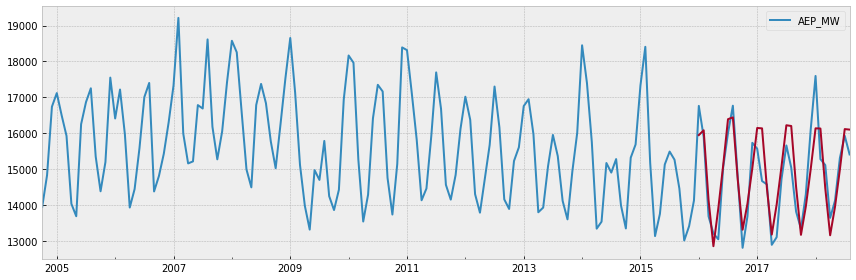

In [34]:
df_monthly.plot()
res.forecast(32).plot()
plt.tight_layout()

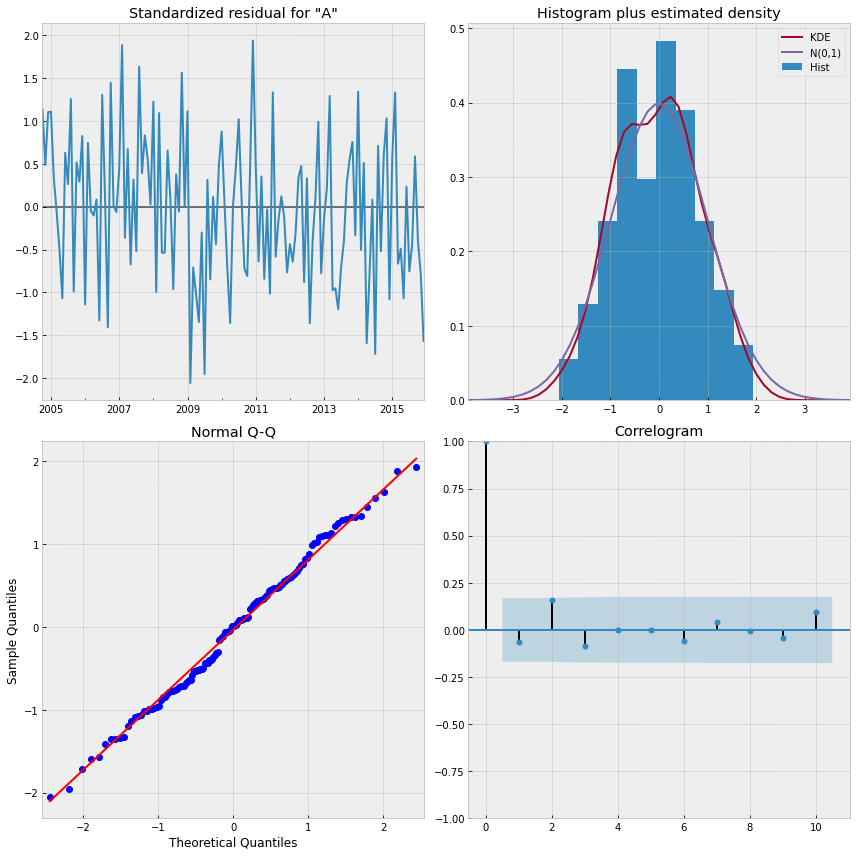

In [39]:
res.plot_diagnostics(figsize=(12,12))
plt.tight_layout()
plt.show()